In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from nilearn.plotting import plot_glass_brain
import pandas as pd
import os
from os.path import join

### Setup

In [4]:
AFFINE = nib.load('TripleEvents_parcels/fROIs_filtered_overlap60_minsize200.nii').affine

def load_img(nii_path):
    img = nib.load(nii_path)
    if not np.array_equal(img.affine, AFFINE):
        raise ValueError('Unexpected affine')
    return img.get_fdata()


def load_parcels():
    left_inf_pole = load_img('ATL_parcels/left_inferior_pole.nii')
    left_inf_pole_middle = load_img('ATL_parcels/left_inferior_pole_middle.nii')
    right_inf_pole = load_img('ATL_parcels/right_inferior_pole.nii')
    right_inf_pole_middle = load_img('ATL_parcels/right_inferior_pole_middle.nii')
    tripleevents = load_img('TripleEvents_parcels/fROIs_filtered_overlap60_minsize200.nii')
    tripleevents[tripleevents>0] = 1 #creating a general tripleevents mask

    region_1 = load_img('TripleEvents_parcels/region_1.nii')
    region_2 = load_img('TripleEvents_parcels/region_2.nii')
    region_3 = load_img('TripleEvents_parcels/region_3.nii')
    region_4 = load_img('TripleEvents_parcels/region_4.nii')
    region_5 = load_img('TripleEvents_parcels/region_5.nii')
    region_6 = load_img('TripleEvents_parcels/region_6.nii')
    region_7 = load_img('TripleEvents_parcels/region_7.nii')
    region_8 = load_img('TripleEvents_parcels/region_8.nii')
    region_9 = load_img('TripleEvents_parcels/region_9.nii')
    region_10 = load_img('TripleEvents_parcels/region_10.nii')
    region_11 = load_img('TripleEvents_parcels/region_11.nii')
        
    return left_inf_pole, left_inf_pole_middle, right_inf_pole, right_inf_pole_middle, tripleevents, region_1, region_2, region_3, region_4, region_5, region_6, region_7, region_8, region_9, region_10, region_11


def split_tripleevents_parcel():
    '''
    splitting tripleevents parcels into individual regions
    produces the parcels in TripleEvents_parcels/
    '''
    tripleevents = load_img('TripleEvents_parcels/fROIs_filtered_overlap60_minsize200.nii')

    unique_ids = np.unique(tripleevents)
    for id in unique_ids:
        region_mask = np.zeros(tripleevents.shape)
        region_ids = np.where(tripleevents == id)
        region_mask[region_ids] = 1
        mask_img = nib.Nifti1Image(region_mask, affine=AFFINE)
        nib.save(mask_img, f'TripleEvents_parcels/region_{round(id)}.nii')


# Function to determine new column values
def determine_label(parcel_type):
    if parcel_type in triple_events_dict.values():
        return 'triple_events'
    elif parcel_type in atl_dict.values():
        return 'atl'
    else:
        return None  # or any other default value

### Label Mapping Definition

In [5]:
# Loading parcels
left_inf_pole, left_inf_pole_middle, right_inf_pole, right_inf_pole_middle, tripleevents, region_1, region_2, region_3, region_4, region_5, region_6, region_7, region_8, region_9, region_10, region_11 = load_parcels()
parcel_used = ['left_inf_pole', 'left_inf_pole_middle', 'right_inf_pole', 'right_inf_pole_middle', 
                'region_1', 'region_2', 'region_3', 'region_4', 'region_5', 
                'region_6', 'region_7', 'region_8', 'region_9', 'region_10', 
                'region_11']

# Label mapping for plotting
triple_events_dict = {
    'region_1': 'F2',
    'region_2': 'F1',
    'region_3': 'TP3',
    'region_4': 'TP2',
    'region_5': 'Cer1',
    'region_6': 'TP4',
    'region_7': 'F3',
    'region_8': 'TP1',
    'region_9': 'O1',
    'region_10': 'Cer2',
    'region_11': 'O2',
}

atl_dict = {
    'left_inf_pole': 'lATL (inf+pole)',
    'left_inf_pole_middle': 'lATL (inf+pole+mid)',
    'right_inf_pole': 'rATL (inf+pole)',
    'right_inf_pole_middle': 'rATL (inf+pole+mid)',
}

### Calculate mean tsnr for each parcel

In [7]:
label_mapping = {**triple_events_dict, **atl_dict}

# Initializing df columns
subj, func_run, parcel_type, voxel_num_for_average, mean_tsnr = [], [], [], [], []

# Calculate mean tsnr values for each parcel, save in columns
matrix_dir = 'tsnr_matrices'
number_zero = np.log(1e-10)
for dir in os.listdir(matrix_dir):
    for file in os.listdir(join(matrix_dir, dir)):
        tsnr_matrix = np.load(f'{matrix_dir}/{dir}/{file}')
        tsnr_matrix[tsnr_matrix == number_zero] = np.nan
        for parcel_name in parcel_used:
            parcel = globals()[parcel_name]
            # Masking out values outside of parcel boundry
            filtered_tsnr_matrix = tsnr_matrix * parcel
            # Setting 0 to nans for values corresponding to 0s in parcels
            mask = (parcel == 0)
            filtered_tsnr_matrix[mask] = np.nan
            # Taking mean, ignoring NAs
            mean_tsnr_value = np.nanmean(filtered_tsnr_matrix)
            # Number of voxels accounted for mean
            voxel_count = np.count_nonzero(~np.isnan(filtered_tsnr_matrix))
            # Recording values
            subj.append(dir)
            func_run.append(file.strip('.npy'))
            parcel_type.append(parcel_name)
            voxel_num_for_average.append(voxel_count)
            mean_tsnr.append(mean_tsnr_value)

# Store in DF
df = pd.DataFrame({
    'subj': subj,
    'func_run': func_run,
    'parcel_type': parcel_type,
    'voxel_num_for_average': voxel_num_for_average,
    'mean_tsnr': mean_tsnr
})

# Map 'parcel_type' using the dictionary
df['parcel_type'] = df['parcel_type'].map(label_mapping).fillna(df['parcel_type'])

# Add a new column indicateing whether parcel is from tripleevents or atl
df['parcel_source'] = df['parcel_type'].apply(determine_label)
df.to_csv('data/mean_tsnr_all_runs.csv')

### Plotting

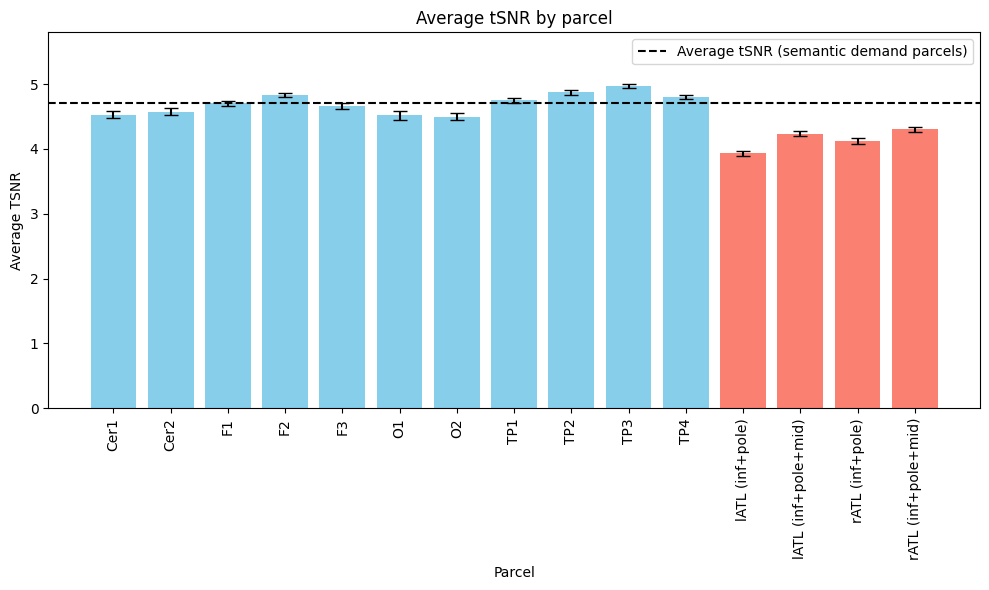

In [23]:
df = pd.read_csv('data/mean_tsnr_all_runs.csv')

# First, calculate the subject-level means of 'mean_tsnr' for each parcel type and parcel source
subject_means = df.groupby(['subj', 'parcel_type', 'parcel_source'])['mean_tsnr'].mean().reset_index()

# Now, calculate the mean and standard error for each parcel type and parcel source
mean_values = subject_means.groupby(['parcel_type', 'parcel_source']).agg(
    mean=('mean_tsnr', 'mean'),
    std=('mean_tsnr', 'std'),
    n_subjs=('subj', 'nunique')
).reset_index()

# Calculate the standard error for each parcel type
mean_values['sem'] = mean_values['std'] / np.sqrt(mean_values['n_subjs'])

# Set colors based on 'parcel_source'
colors = np.where(mean_values['parcel_source'] == 'triple_events', 'skyblue', 'salmon')

# Calculate the average 'mean_tsnr' for 'triple_events'
average_triple_events = subject_means[subject_means['parcel_source'] == 'triple_events']['mean_tsnr'].mean()

# Plot
plt.figure(figsize=(10, 6))
plt.bar(mean_values['parcel_type'], mean_values['mean'], yerr=mean_values['sem'], color=colors, capsize=5)
plt.axhline(y=average_triple_events, color='black', linestyle='--', label='Average tSNR (semantic demand parcels)')
plt.xlabel('Parcel')
plt.ylabel('Average TSNR')
plt.ylim(0, 5.8)
plt.title('Average tSNR by parcel')
plt.xticks(rotation=90)
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.savefig('tsnr_plot.pdf', format='pdf')
plt.show()

In [15]:
# Export as vectorized PDF

plt.savefig('tsnr_plot.pdf', format='pdf')

<Figure size 640x480 with 0 Axes>